In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
import pandas as pd
import json

DB_PATH = 'data/numero.duckdb'

# Connect to DuckDB and query data
def get_data(limit=100):
    with duckdb.connect(DB_PATH) as con:
        table_name = con.execute("SHOW TABLES").fetchall()
        df = con.execute(f"SELECT * FROM {table_name[0][0]}").df()
    return df

df_json = get_data()
# Parse and explode 'films' from JSON in 'data' column
def JSON_to_DF(df_json):
    df = df_json.copy()
    df['films'] = df['data'].dropna().apply(lambda x: json.loads(x)['films'])
    df = df.explode('films').reset_index(drop=True)
    json_expanded = pd.json_normalize(df['films'])
    json_expanded.columns = [f"data.films.{col}" for col in json_expanded.columns]
    df = df.drop(columns=['data', 'films']).join(json_expanded)
    df.columns = [col.replace("data.films.", "") for col in df.columns]
    return df
df = JSON_to_DF(df_json)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27089 entries, 0 to 27088
Data columns (total 30 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   week_date                        27089 non-null  datetime64[us]
 1   filename                         27089 non-null  object        
 2   censorRating                     27012 non-null  object        
 3   distributorId                    27089 non-null  int64         
 4   distributorName                  27089 non-null  object        
 5   filmId                           27089 non-null  int64         
 6   playWeek                         27089 non-null  int64         
 7   previousWeekRank                 13316 non-null  float64       
 8   rank                             27089 non-null  int64         
 9   releaseDate                      27089 non-null  object        
 10  title                            27089 non-null  object   

#'previous' features missing a half. 1/20 films have data for 'opening' features.

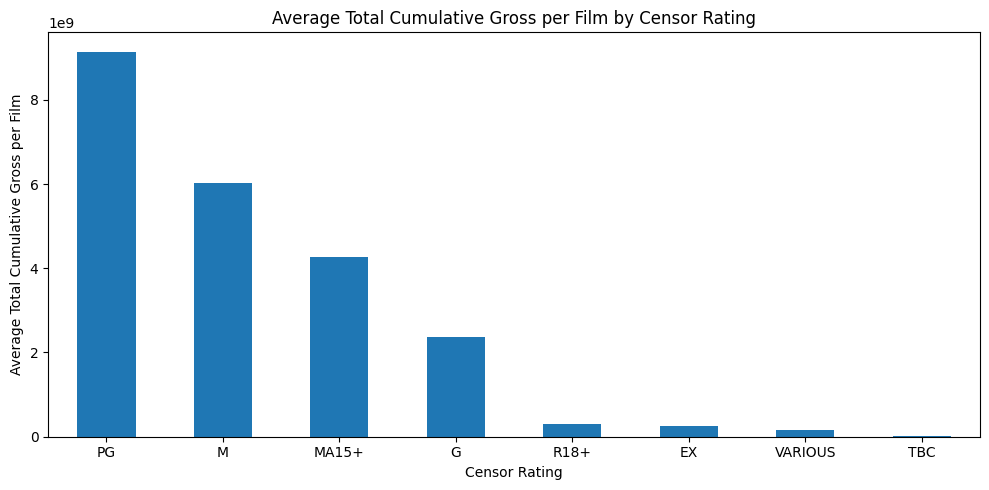

In [2]:
if 'censorRating' in df.columns and 'title' in df.columns:
    gross_cols = [
        'previousWeek.cumulativeGross',
        'previousWeekend.cumulativeGross',
        'week.cumulativeGross',
        'weekend.cumulativeGross'
    ]
    # Only use columns that exist
    valid_cols = [c for c in gross_cols if c in df.columns]
    if valid_cols:
        df['total_cumulativeGross'] = df[valid_cols].sum(axis=1)
        # Sum total_cumulativeGross per film
        film_gross = df.groupby(['censorRating', 'title'])['total_cumulativeGross'].sum().reset_index()
        # Average per censorRating
        rating_avg = film_gross.groupby('censorRating')['total_cumulativeGross'].mean().sort_values(ascending=False)
        plt.figure(figsize=(10, 5))
        rating_avg.plot(kind='bar')
        plt.title('Average Total Cumulative Gross per Film by Censor Rating')
        plt.xlabel('Censor Rating')
        plt.xticks(rotation=0)
        plt.ylabel('Average Total Cumulative Gross per Film')
        plt.tight_layout()
        plt.show()

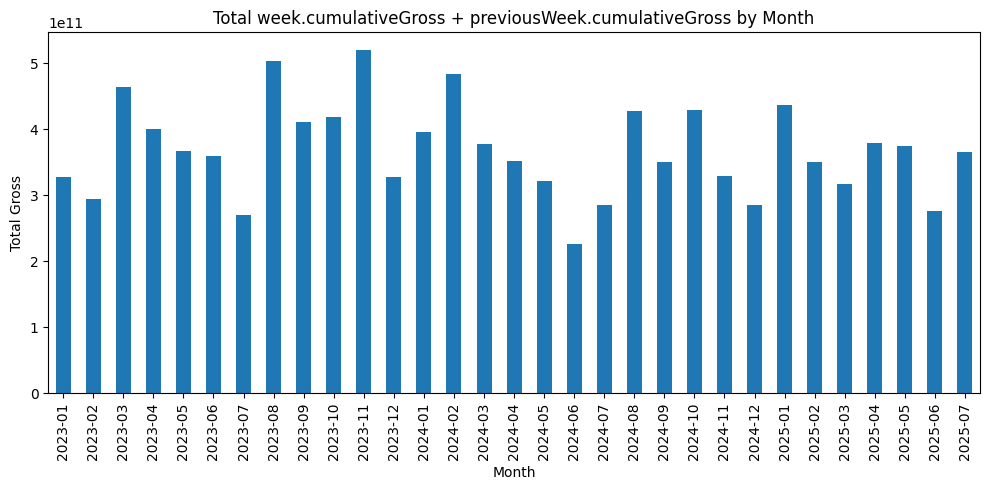

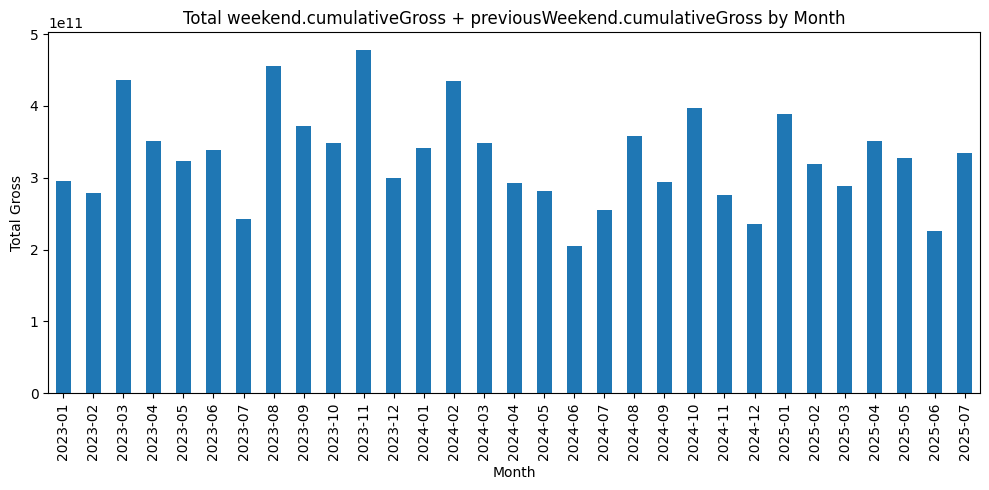

In [3]:
# Monthly aggregation for week, weekend, previousWeek, previousWeekend cumulativeGross
date_col = None
for col in ['week_date', 'releaseDate']:
    if col in df.columns:
        date_col = col
        break

gross_types = [
    ('week.cumulativeGross', 'previousWeek.cumulativeGross'),
    ('weekend.cumulativeGross', 'previousWeekend.cumulativeGross')
]

if date_col:
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    df['month'] = df[date_col].dt.to_period('M')
    df['is_first_week'] = df.groupby('month')[date_col].transform('min') == df[date_col]
    for week_col, prev_col in gross_types:
        if week_col in df.columns and prev_col in df.columns:
            df[f'monthly_{week_col}'] = df[week_col]
            mask = ~df['is_first_week']
            df.loc[mask, f'monthly_{week_col}'] = df.loc[mask, week_col].fillna(0) + df.loc[mask, prev_col].fillna(0)
            monthly_gross = df.groupby('month')[f'monthly_{week_col}'].sum().sort_index()
            plt.figure(figsize=(10, 5))
            monthly_gross.plot(kind='bar')
            plt.title(f'Total {week_col} + {prev_col} by Month')
            plt.xlabel('Month')
            plt.ylabel('Total Gross')
            plt.tight_layout()
            plt.show()

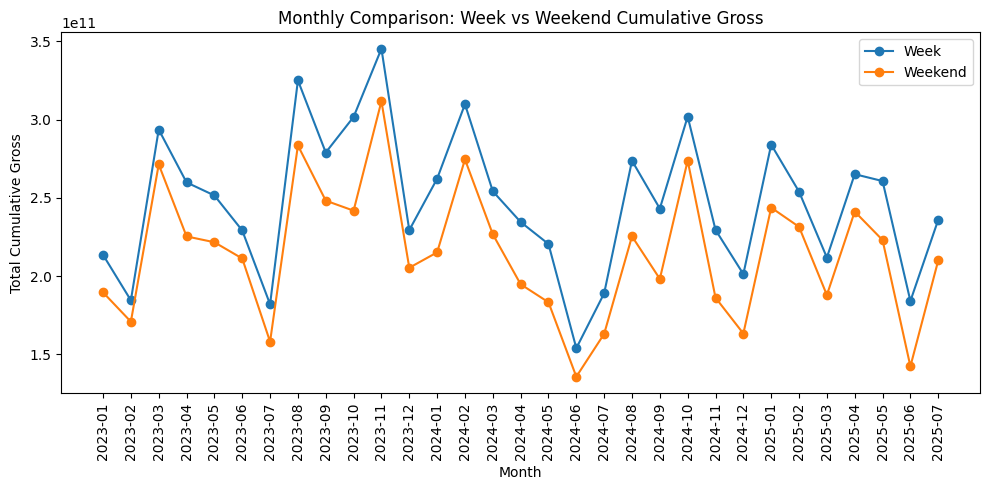

In [4]:
if date_col and 'week.cumulativeGross' in df.columns and 'weekend.cumulativeGross' in df.columns:
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    df['month'] = df[date_col].dt.to_period('M')
    week_monthly = df.groupby('month')['week.cumulativeGross'].sum().sort_index()
    weekend_monthly = df.groupby('month')['weekend.cumulativeGross'].sum().sort_index()
    plt.figure(figsize=(10, 5))
    plt.plot(week_monthly.index.astype(str), week_monthly.values, marker='o', label='Week')
    plt.plot(weekend_monthly.index.astype(str), weekend_monthly.values, marker='o', label='Weekend')
    plt.title('Monthly Comparison: Week vs Weekend Cumulative Gross')
    plt.xlabel('Month')
    plt.ylabel('Total Cumulative Gross')
    plt.xticks(rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.show()

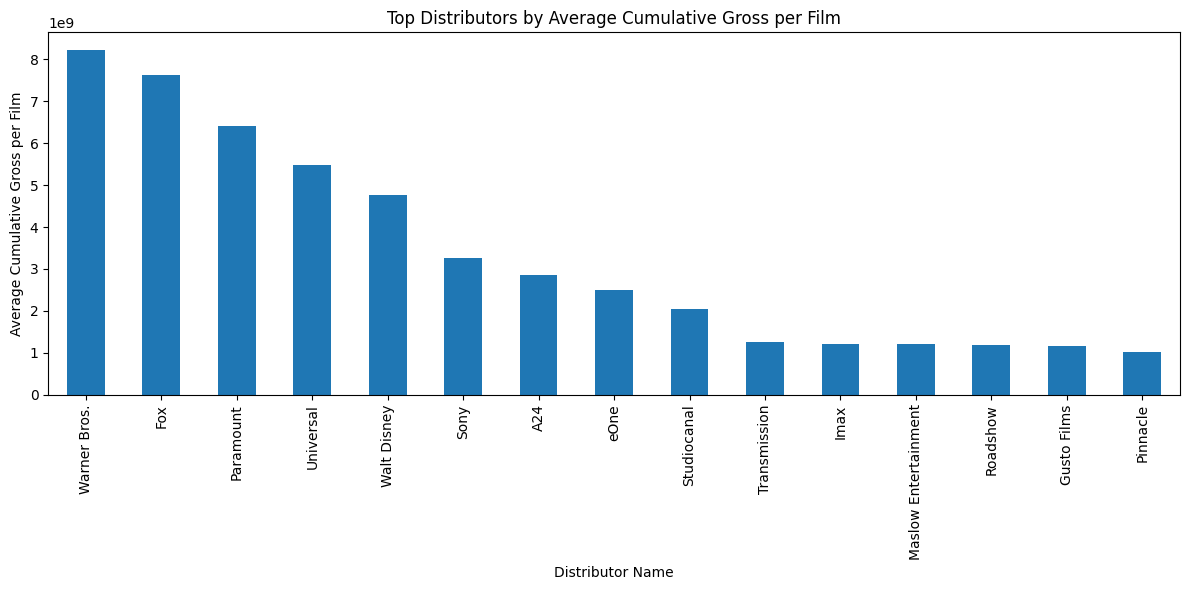

In [5]:
# Plot top distributors by average cumulative gross per film
if 'distributorName' in df.columns and 'week.cumulativeGross' in df.columns and 'title' in df.columns:
    film_gross = df.groupby(['distributorName', 'title'])['week.cumulativeGross'].sum().reset_index()
    dist_avg = film_gross.groupby('distributorName')['week.cumulativeGross'].mean().sort_values(ascending=False)
    plt.figure(figsize=(12, 6))
    dist_avg.head(15).plot(kind='bar')
    plt.title('Top Distributors by Average Cumulative Gross per Film')
    plt.xlabel('Distributor Name')
    plt.ylabel('Average Cumulative Gross per Film')
    plt.tight_layout()
    plt.show()

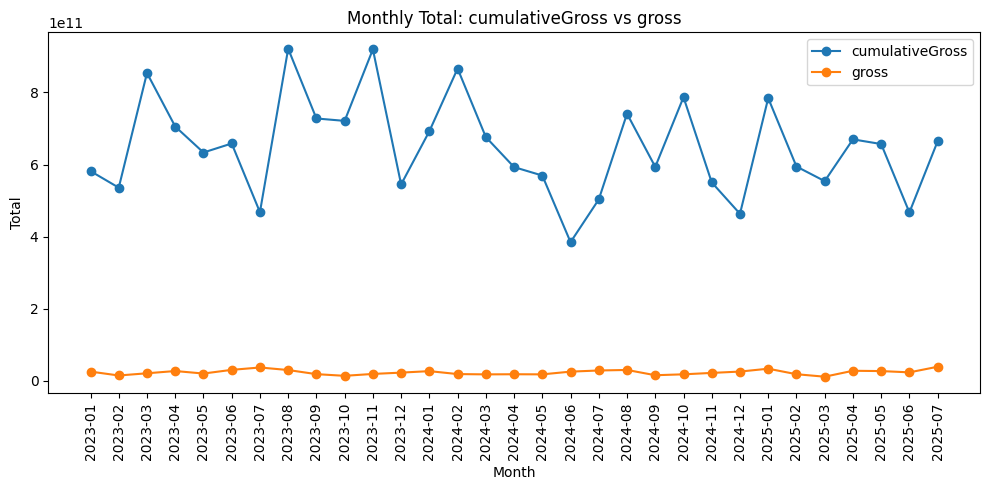

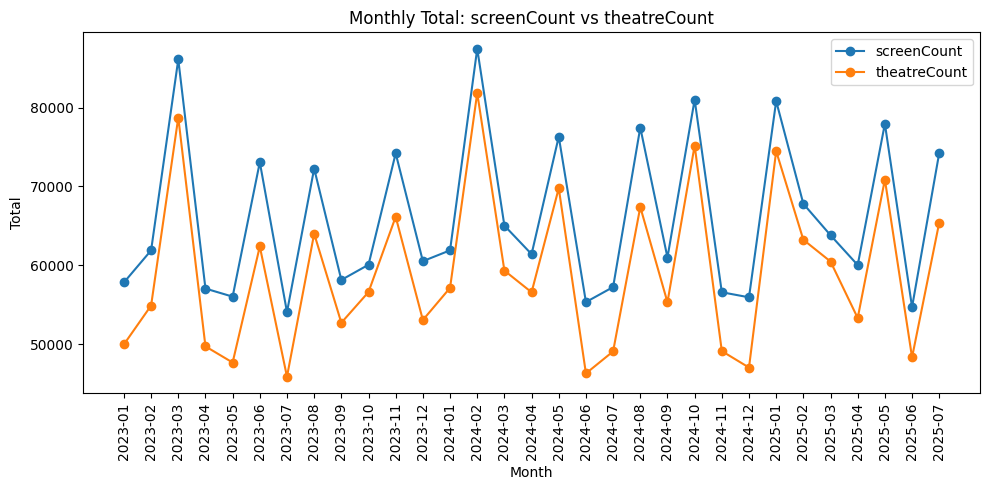

In [8]:
# Line chart comparing monthly totals for cumulativeGross, gross, screenCount, theatreCount
metrics = [
    ('cumulativeGross', ['previousWeek.cumulativeGross', 'previousWeekend.cumulativeGross', 'week.cumulativeGross', 'weekend.cumulativeGross']),
    ('gross', ['previousWeek.gross', 'previousWeekend.gross', 'week.gross', 'weekend.gross']),
    ('screenCount', ['previousWeek.screenCount', 'previousWeekend.screenCount', 'week.screenCount', 'weekend.screenCount']),
    ('theatreCount', ['previousWeek.theatreCount', 'previousWeekend.theatreCount', 'week.theatreCount', 'weekend.theatreCount'])
]

if date_col:
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    df['month'] = df[date_col].dt.to_period('M')
    df['is_first_week'] = df.groupby('month')[date_col].transform('min') == df[date_col]
    monthly_totals = {}
    for metric, cols in metrics:
        # Only use columns that exist
        valid_cols = [c for c in cols if c in df.columns]
        if not valid_cols:
            continue
        # For first week: only week+weekend, else sum all
        week_cols = [c for c in valid_cols if c.startswith('week.')]
        prev_cols = [c for c in valid_cols if c.startswith('previousWeek') or c.startswith('previousWeekend')]
        df[f'monthly_{metric}'] = 0
        # For first week: only week+weekend
        df.loc[df['is_first_week'], f'monthly_{metric}'] = df.loc[df['is_first_week'], week_cols].sum(axis=1)
        # For other weeks: sum all
        df.loc[~df['is_first_week'], f'monthly_{metric}'] = df.loc[~df['is_first_week'], valid_cols].sum(axis=1)
        monthly_totals[metric] = df.groupby('month')[f'monthly_{metric}'].sum().sort_index()
    # Plot each metric on a separate line chart
    # Plot cumulativeGross and gross together
    plt.figure(figsize=(10, 5))
    plt.plot(monthly_totals['cumulativeGross'].index.astype(str), monthly_totals['cumulativeGross'].values, marker='o', label='cumulativeGross')
    plt.plot(monthly_totals['gross'].index.astype(str), monthly_totals['gross'].values, marker='o', label='gross')
    plt.title('Monthly Total: cumulativeGross vs gross')
    plt.xlabel('Month')
    plt.ylabel('Total')
    plt.xticks(rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot screenCount and theatreCount together
    plt.figure(figsize=(10, 5))
    plt.plot(monthly_totals['screenCount'].index.astype(str), monthly_totals['screenCount'].values, marker='o', label='screenCount')
    plt.plot(monthly_totals['theatreCount'].index.astype(str), monthly_totals['theatreCount'].values, marker='o', label='theatreCount')
    plt.title('Monthly Total: screenCount vs theatreCount')
    plt.xlabel('Month')
    plt.ylabel('Total')
    plt.xticks(rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.show()

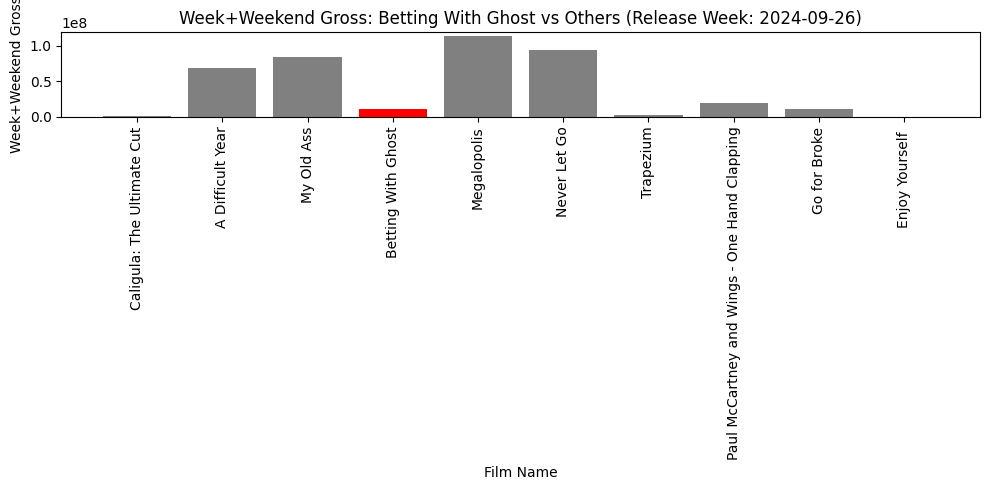

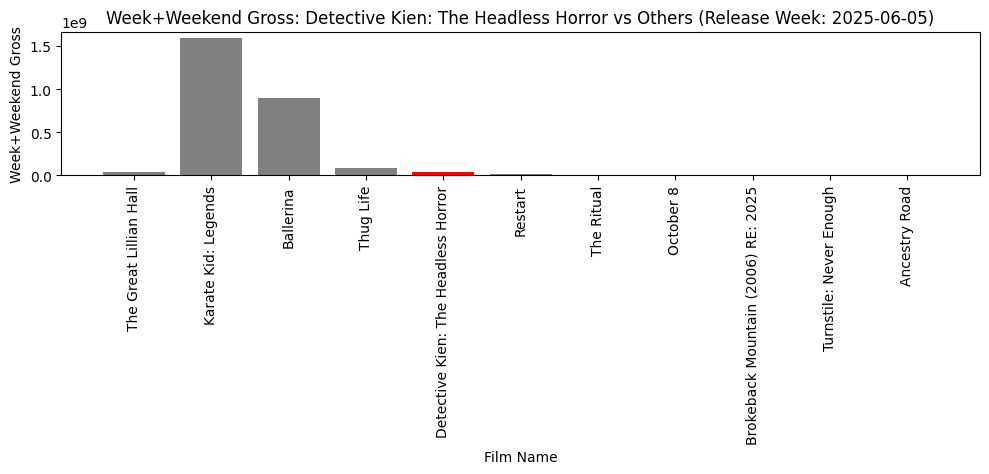

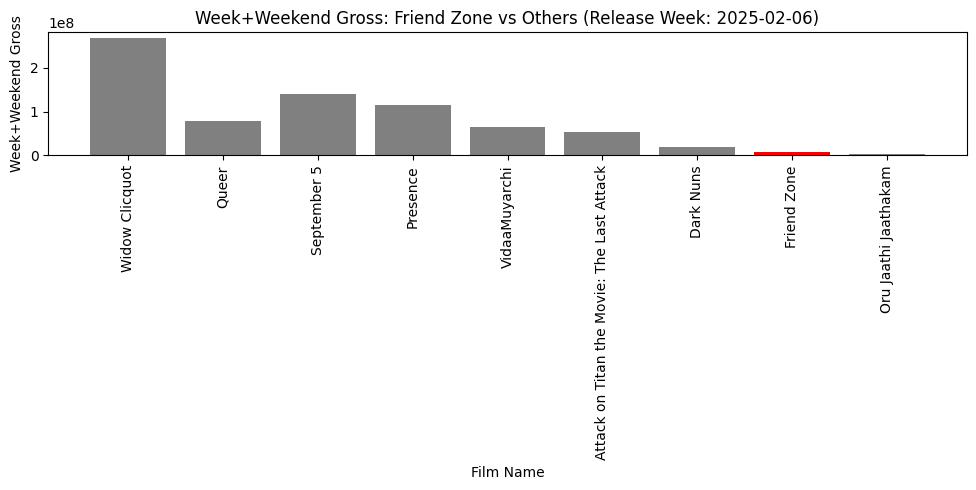

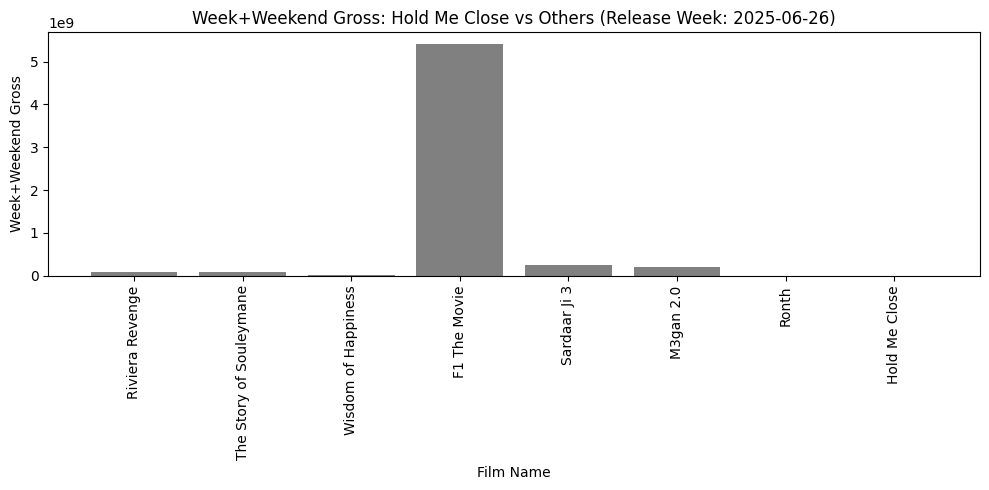

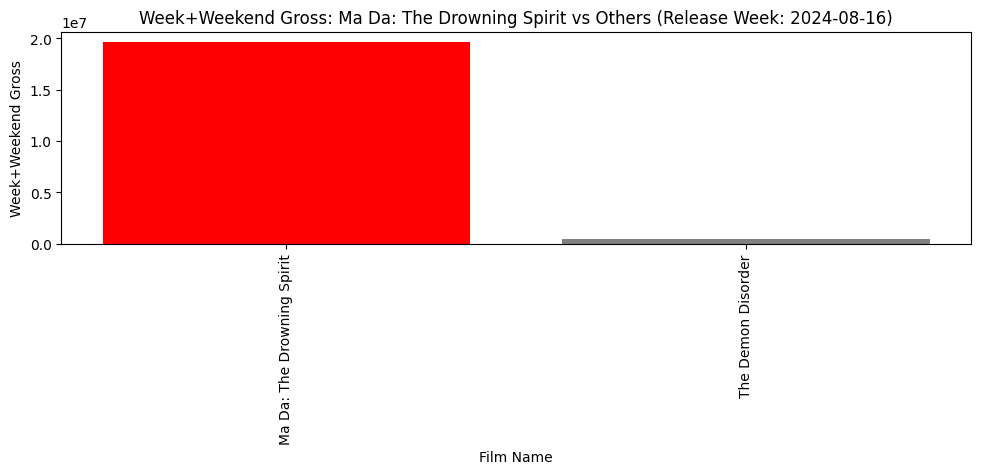

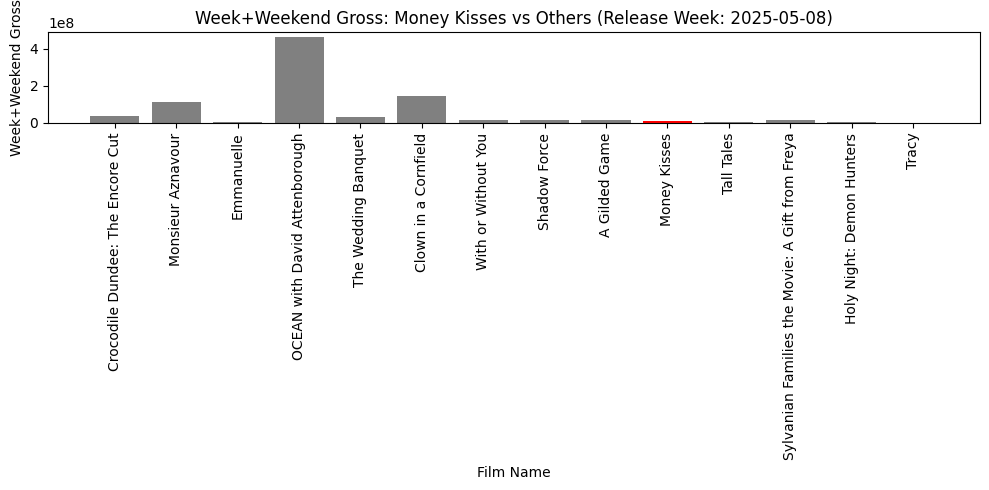

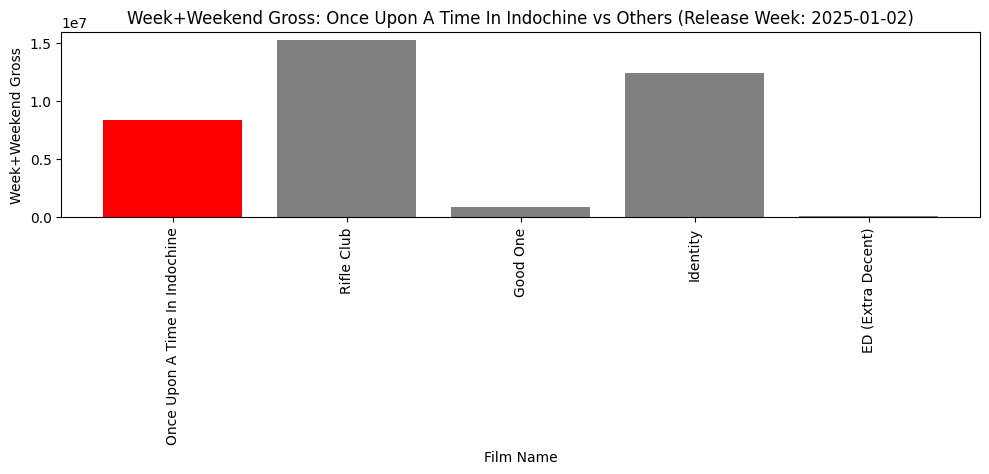

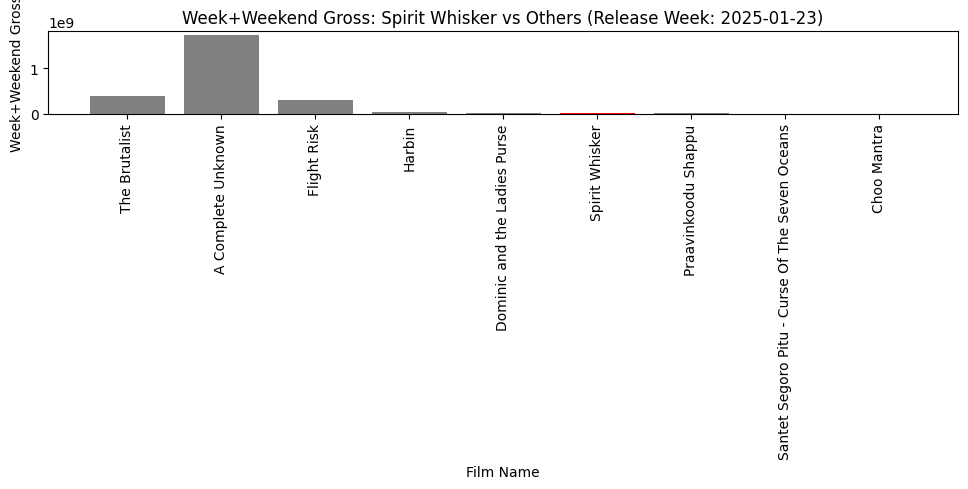

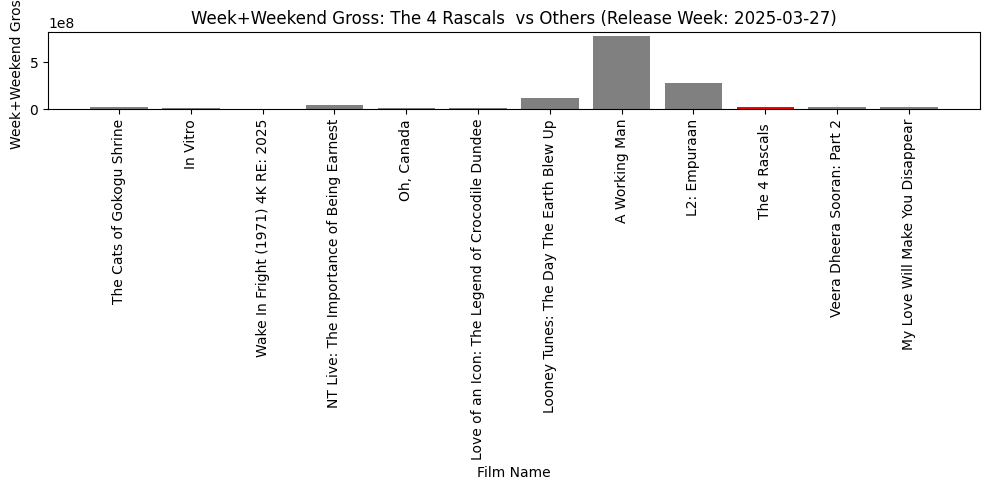

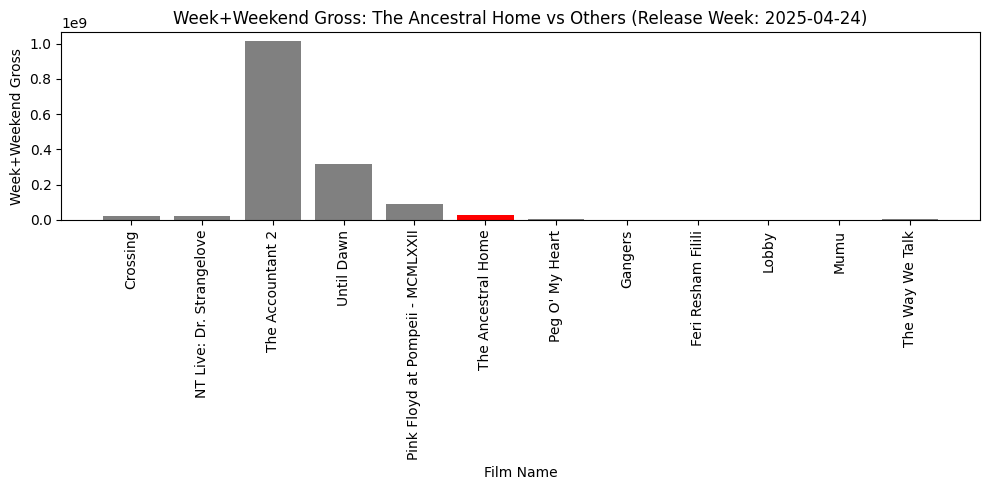

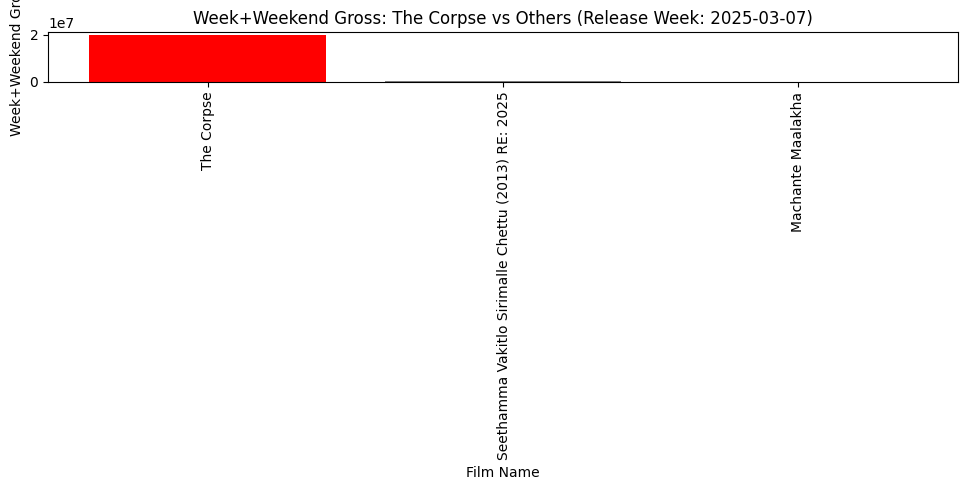

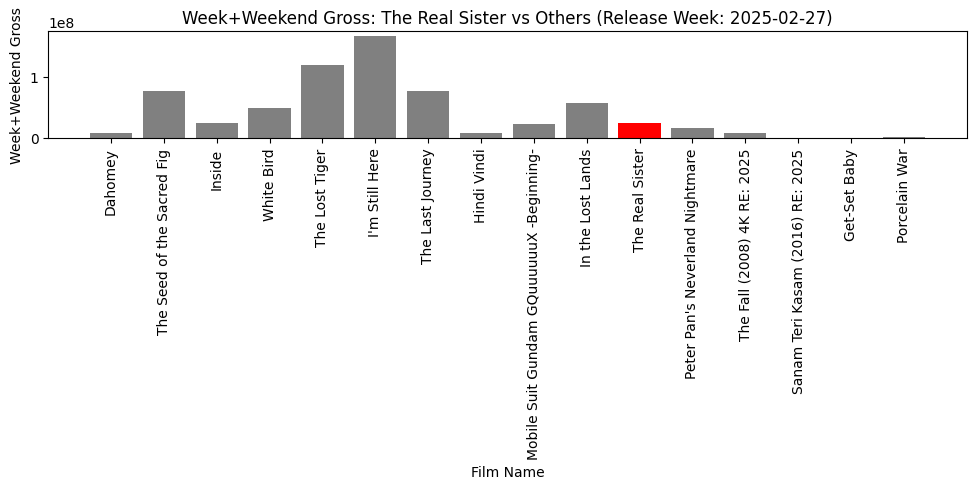

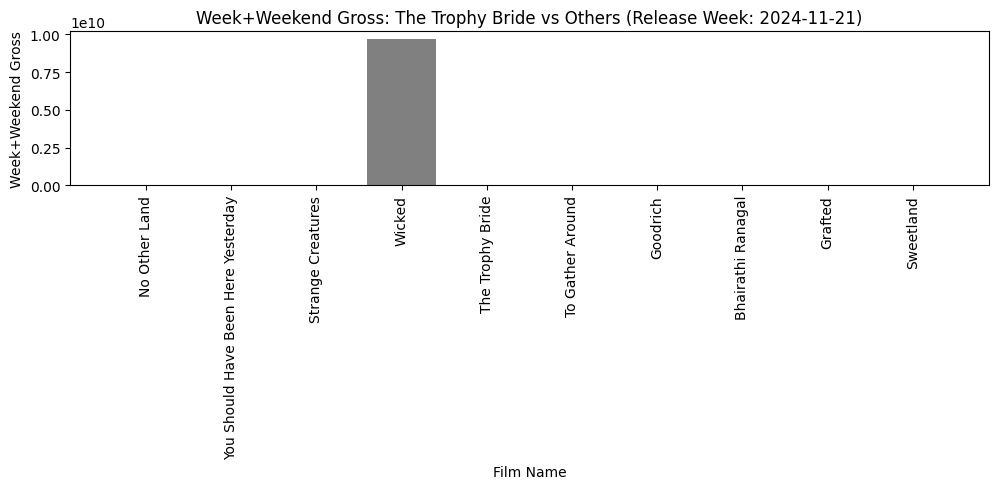

In [9]:
if 'distributorName' in df.columns and 'title' in df.columns and 'week.cumulativeGross' in df.columns and 'weekend.cumulativeGross' in df.columns and 'releaseDate' in df.columns:
    df['releaseDate'] = pd.to_datetime(df['releaseDate'], errors='coerce')
    # Calculate total gross for each film in each week
    df['week_total_gross'] = df['week.cumulativeGross'] + df['weekend.cumulativeGross']
    # Filter Infinity Group Films
    infinity_df = df[df['distributorName'].str.lower() == 'infinity group films']
    # For each Infinity Group film, compare to all films released the same week
    for film, group in infinity_df.groupby('title'):
        week = group['releaseDate'].iloc[0]
        week_films = df[df['releaseDate'] == week]
        plt.figure(figsize=(10, 5))
        plt.bar(week_films['title'], week_films['week_total_gross'], color=['red' if f == film else 'gray' for f in week_films['title']])
        plt.title(f'Week+Weekend Gross: {film} vs Others (Release Week: {week.date()})')
        plt.xlabel('Film Name')
        plt.ylabel('Week+Weekend Gross')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()